# **First Code**

✅ Cell 1: Install Dependencies

In [1]:
# Install specific versions
!pip install pytorch-lightning==2.4.0 pytorch-forecasting==1.4.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ Cell 2: Load and Prepare the Data

/tmp/ipython-input-3623917483.py:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['week_start_date'] = pd.to_datetime(df['week_start_date'])
/tmp/ipython-input-3623917483.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3623917483.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


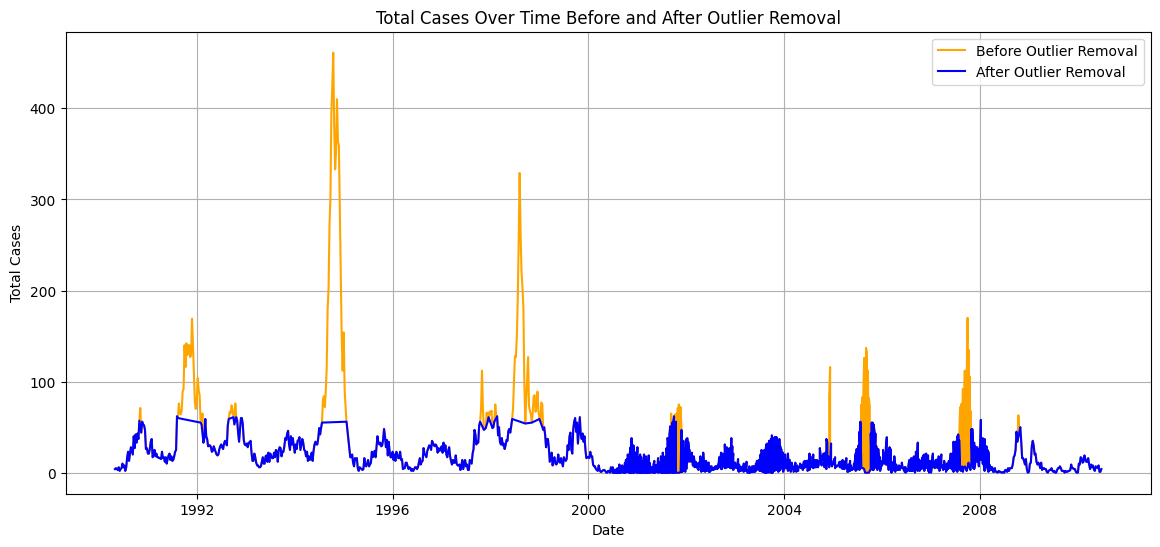

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/sample_data/dengue data 17-07-2025.csv")

# Convert date column
df['week_start_date'] = pd.to_datetime(df['week_start_date'])

# Fill missing values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Extract date features
df['month'] = df['week_start_date'].dt.month
df['day'] = df['week_start_date'].dt.day
df['dayofweek'] = df['week_start_date'].dt.dayofweek
df['year'] = df['week_start_date'].dt.year

# Convert city to categorical code
df['city'] = df['city'].astype('category').cat.codes

# Sort and create continuous time index
df = df.sort_values('week_start_date').reset_index(drop=True)
df['time_idx'] = df.index

# Plot total_cases over time before and after outlier removal
plt.figure(figsize=(14, 6))
plt.plot(df['week_start_date'], df['total_cases'], label='Before Outlier Removal', color='orange')

# Define IQR bounds
Q1 = df["total_cases"].quantile(0.25)
Q3 = df["total_cases"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_cleaned = df[(df["total_cases"] >= lower_bound) & (df["total_cases"] <= upper_bound)]

# Plot total_cases after outlier removal
plt.plot(df_cleaned['week_start_date'], df_cleaned['total_cases'], label='After Outlier Removal', color='blue')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.title('Total Cases Over Time Before and After Outlier Removal')
plt.legend()
plt.grid(True)
plt.show()

# Update df to cleaned data and reset time_idx
df = df_cleaned.sort_values("week_start_date").reset_index(drop=True)
df["time_idx"] = df.index


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1332 non-null   int8          
 1   year                                   1332 non-null   int32         
 2   weekofyear                             1332 non-null   int64         
 3   week_start_date                        1332 non-null   datetime64[ns]
 4   ndvi_ne                                1332 non-null   float64       
 5   ndvi_nw                                1332 non-null   float64       
 6   ndvi_se                                1332 non-null   float64       
 7   ndvi_sw                                1332 non-null   float64       
 8   precipitation_amt_mm                   1332 non-null   float64       
 9   reanalysis_air_temp_k                  1332 non-null   float64 

✅ Cell 3: Train/Test Split

In [ ]:
# # 80/20 split
# train_size = int(len(df) * 0.8)
# train_df = df.iloc[:train_size].copy()
# test_df = df.iloc[train_size:].copy()

# print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
train_df_list = []
test_df_list = []

for city, city_df in df.groupby("city"):
    city_df = city_df.sort_values("time_idx").reset_index(drop=True)
    split_idx = int(len(city_df) * 0.8)
    train_df_list.append(city_df.iloc[:split_idx])
    test_df_list.append(city_df.iloc[split_idx:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

print("Train size:", len(train_df), "Test size:", len(test_df))
print("Cities in train:", train_df["city"].unique())
print("Cities in test:", test_df["city"].unique())


Train size: 1065 Test size: 267
Cities in train: [0 1]
Cities in test: [0 1]


✅ Cell 4: Prepare TimeSeriesDataSet

In [ ]:
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning import seed_everything

seed_everything(42)

# Define features
features = [
    'city', 'year', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
    'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_tdtr_k',
    'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
    'station_min_temp_c', 'station_precip_mm', 'month', 'day', 'dayofweek'
]

target = 'total_cases'
max_encoder_length = 30
max_prediction_length = 10
training_cutoff = train_df["time_idx"].max() - max_prediction_length

# Create training dataset
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=target,
    group_ids=["city"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"] + features,
    time_varying_unknown_reals=[target],
    target_normalizer=GroupNormalizer(groups=["city"]),
    allow_missing_timesteps=True
)

# Validation dataset
validation = TimeSeriesDataSet.from_dataset(training, test_df, stop_randomization=True)


INFO:lightning_fabric.utilities.seed:Seed set to 42


✅ Cell 5: Create DataLoaders

In [ ]:
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)



✅ Cell 6: Define and Train TFT Model

In [ ]:
import lightning.pytorch as L
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
import torch

torch.set_float32_matmul_precision("medium")

early_stop = EarlyStopping(monitor="val_loss", patience=10, mode="min")
lr_logger = LearningRateMonitor(logging_interval="epoch")

trainer = L.Trainer(
    max_epochs=30,
    gradient_clip_val=0.1,
    callbacks=[early_stop, lr_logger],
    accelerator="auto",
    devices=1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.005,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=64,
    output_size=7,               # quantiles
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=5
)

print("Is LightningModule?", isinstance(tft, L.LightningModule))

trainer.fit(
    model=tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparamete

Is LightningModule? True


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

✅ Cell 7: Evaluate the Model

In [ ]:
# best_model_path = trainer.checkpoint_callback.best_model_path
# best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# # Predictions with metadata
# raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

# # Convert to DataFrame for easier filtering
# pred_df = training.dataset_to_dataframe(x, predictions=raw_predictions)

# # Add true values
# pred_df["actual"] = pred_df["total_cases"]
# pred_df["forecast"] = pred_df["prediction"]

#-***********************************************************************************************
# # Get raw predictions including inputs
# raw_output = best_model.predict(val_dataloader, mode="raw", return_x=True)

# # raw_output is a dictionary with 'prediction' and 'x'
# predictions = raw_output["prediction"]  # forecasts
# x = raw_output["x"]                    # inputs

# # Convert to DataFrame
# pred_df = training.dataset_to_dataframe(x, predictions=predictions)

# # Add true values + forecast column
# pred_df["actual"] = pred_df["total_cases"]
# pred_df["forecast"] = pred_df["prediction"]
#************************************************************************************************

# import pandas as pd

# # Get predictions + inputs
# raw_output = best_model.predict(val_dataloader, mode="raw", return_x=True)

# # raw_output is a tuple → (predictions, x)
# predictions = raw_output[0]
# x = raw_output[1]

# # Extract true values from x
# y_true = x[0]["target"]  # actual targets in validation
# time_idx = x[0]["time_idx"]
# cities = x[0]["groups"]["city"]

# # Convert to numpy
# y_true = y_true.detach().cpu().numpy().flatten()
# y_pred = predictions.detach().cpu().numpy().flatten()
# time_idx = time_idx.detach().cpu().numpy().flatten()
# cities = cities.detach().cpu().numpy().flatten()

# # Build DataFrame
# pred_df = pd.DataFrame({
#     "time_idx": time_idx,
#     "city": cities,
#     "actual": y_true,
#     "forecast": y_pred
# })

# print(pred_df.head())



/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/base/_base_model.py:122: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 10, 4, 30]). Returning list instead of torch.Tensor.
  warnings.warn(


TypeError: tuple indices must be integers or slices, not str

In [ ]:
import pandas as pd
import torch

# Get raw output with predictions + inputs
raw_output = best_model.predict(val_dataloader, mode="raw", return_x=True)

predictions = raw_output[0]   # Output object
x = raw_output[1]

# Extract tensor from Output
if hasattr(predictions, "prediction"):
    y_pred_tensor = predictions.prediction
else:
    y_pred_tensor = predictions

# If quantiles → take median
if y_pred_tensor.ndim == 3:  # [batch, time, quantile]
    y_pred_tensor = y_pred_tensor[..., y_pred_tensor.shape[-1] // 2]

# Get actual values from validation dataloader
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])  # shape [batch, time]

# Convert to numpy
y_true = actuals.detach().cpu().numpy()
y_pred = y_pred_tensor.detach().cpu().numpy()

# ✅ Ensure same shape
print("Shapes → y_true:", y_true.shape, "y_pred:", y_pred.shape)

# Flatten only row-wise (batch × decoder_length)
y_true = y_true.reshape(-1)
y_pred = y_pred.reshape(-1)

# ✅ Align lengths with test_df
min_len = min(len(test_df), len(y_true))
pred_df = test_df.iloc[:min_len].copy().reset_index(drop=True)
pred_df["actual"] = y_true[:min_len]
pred_df["forecast"] = y_pred[:min_len]

print(pred_df.head(), pred_df.shape)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Shapes → y_true: (288, 10) y_pred: (288, 10)
   city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0     0  2008          26      2008-06-24  0.197043  0.277983  0.213943   
1     0  2008          27      2008-07-01  0.304829  0.233671  0.248914   
2     0  2008          28      2008-07-08  0.153850  0.149586  0.329443   
3     0  2008          29      2008-07-15  0.232386  0.213957  0.220300   
4     0  2008          30      2008-07-22  0.327017  0.209117  0.283767   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.265614                 89.88             296.458571  ...   
1  0.255814                  0.00             296.542857  ...   
2  0.132886                  0.00             296.545714  ...   
3  0.198429                 62.84             296.078571  ...   
4  0.309550                 52.36             296.545714  ...   

   station_max_temp_c  station_min_temp_c  station_precip_mm  total_cases  \
0                31.1               

✅ Cell 8: Plot Actual vs Predicted

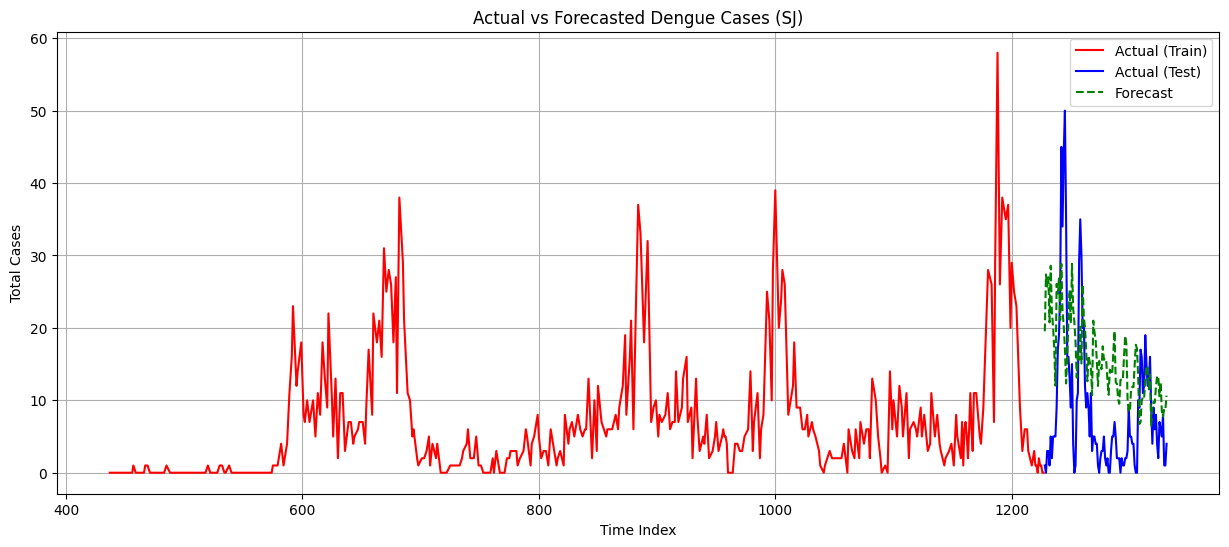

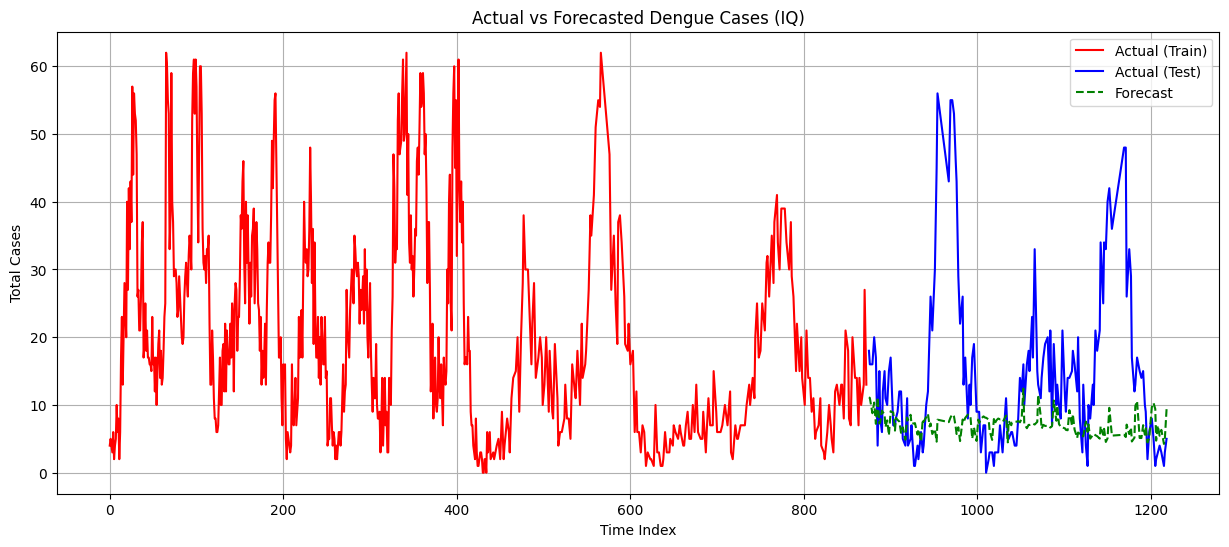

In [ ]:
city_map = {0: "sj", 1: "iq"}

for city_code, city_name in city_map.items():
    city_train = train_df[train_df["city"] == city_code]
    city_test = test_df[test_df["city"] == city_code]
    city_preds = pred_df[pred_df["city"] == city_code]

    plt.figure(figsize=(15, 6))

    # Actual (full historical data)
    plt.plot(city_train["time_idx"], city_train["total_cases"], color="red", label="Actual (Train)")

    # Test actuals
    plt.plot(city_test["time_idx"], city_test["total_cases"], color="blue", label="Actual (Test)")

    # Forecasts
    plt.plot(city_preds["time_idx"], city_preds["forecast"], color="green", linestyle="--", label="Forecast")

    plt.title(f"Actual vs Forecasted Dengue Cases ({city_name.upper()})")
    plt.xlabel("Time Index")
    plt.ylabel("Total Cases")
    plt.legend()
    plt.grid(True)
    plt.show()


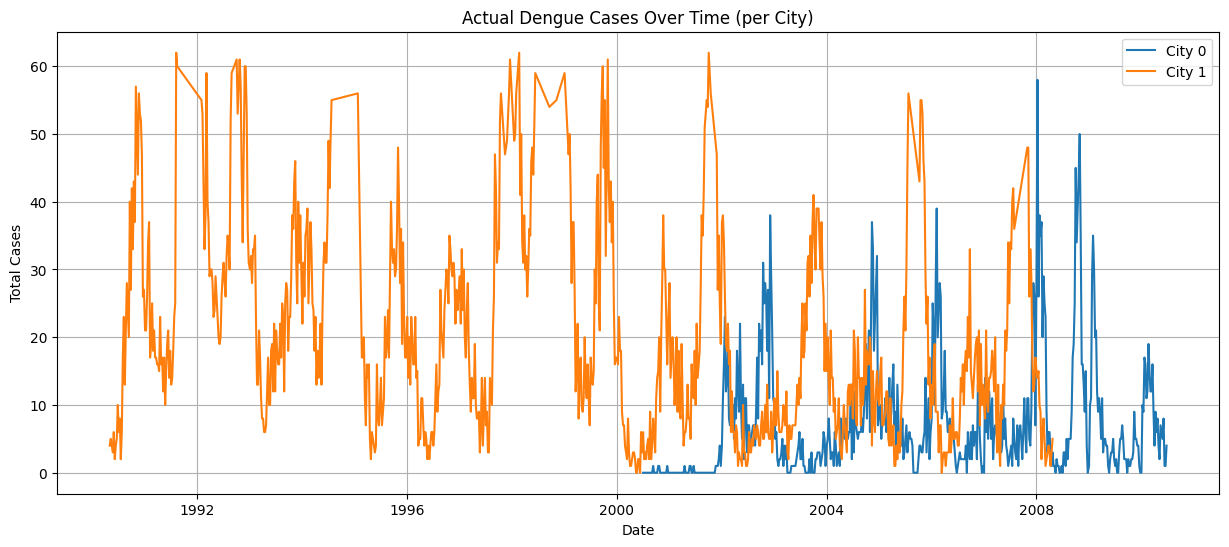

In [ ]:
import matplotlib.pyplot as plt

# Plot actual dengue cases for both cities
plt.figure(figsize=(15, 6))

for city, city_df in df.groupby("city"):
    plt.plot(city_df["week_start_date"], city_df["total_cases"], label=f"City {city}")

plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.title("Actual Dengue Cases Over Time (per City)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# If predictions have shape [samples, prediction_length, quantiles]
if y_pred.ndim == 3:
    median_idx = y_pred.shape[-1] // 2
    y_pred = y_pred[..., median_idx].flatten()


In [ ]:
# -----------------------------
# Cell 7: Evaluate best model
# -----------------------------
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# Get raw predictions
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

# Extract actuals and predictions
y_true = x["decoder_target"].detach().cpu().numpy().flatten()
y_pred = raw_predictions.output.detach().cpu().numpy().flatten()

# Compute metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"Overall Metrics:")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")

# Decode city IDs
city_ids = x["groups"].squeeze().cpu().numpy().flatten()
city_mapping = dict(enumerate(df["city"].astype("category").cat.categories))
cities = [city_mapping[c] for c in city_ids]

# Build DataFrame for plotting
results_df = pd.DataFrame({
    "time_idx": x["decoder_time_idx"].detach().cpu().numpy().flatten(),
    "y_true": y_true,
    "y_pred": y_pred,
    "city": cities
})


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/base/_base_model.py:122: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 10, 4, 30]). Returning list instead of torch.Tensor.
  warnings.warn(


ValueError: too many values to unpack (expected 2)

In [ ]:
# -----------------------------
# Cell 8: Plot actual vs forecasted for each city
# -----------------------------
plt.figure(figsize=(15, 6))

for city in results_df["city"].unique():
    df_city = results_df[results_df["city"] == city]
    df_city = df_city.sort_values("time_idx")

    plt.plot(df_city["time_idx"], df_city["y_true"], color="red", label=f"{city} Actual")
    plt.plot(df_city["time_idx"], df_city["y_pred"], color="green", linestyle="--", label=f"{city} Forecast")

plt.title("Actual vs Forecasted Total Cases (Grouped by City)")
plt.xlabel("Time Index")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'results_df' is not defined

<Figure size 1500x600 with 0 Axes>

# **Second code**

Cell 1 — Install & Import

In [1]:
# Cell 1: Install specific versions
!pip install pytorch-lightning==2.4.0 pytorch-forecasting==1.4.0 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Cell 2 — Load & Clean Data

In [2]:
# Cell 2
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load dataset
df = pd.read_csv("/content/sample_data/dengue data 17-07-2025.csv")

# Convert date column
df['week_start_date'] = pd.to_datetime(df['week_start_date'])

# Fill missing values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Extract date features
df['month'] = df['week_start_date'].dt.month
df['day'] = df['week_start_date'].dt.day
df['dayofweek'] = df['week_start_date'].dt.dayofweek
df['year'] = df['week_start_date'].dt.year

# Convert city to categorical code
df['city'] = df['city'].astype('category').cat.codes

# Sort and create continuous time index
df = df.sort_values('week_start_date').reset_index(drop=True)
df['time_idx'] = df.index

# Outlier removal
Q1, Q3 = df["total_cases"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df = df[(df["total_cases"] >= lower) & (df["total_cases"] <= upper)].reset_index(drop=True)
df["time_idx"] = df.index

# Train-test split (per city, 80/20)
train_df_list, test_df_list = [], []
for city, city_df in df.groupby("city"):
    city_df = city_df.sort_values("time_idx").reset_index(drop=True)
    split_idx = int(len(city_df) * 0.6)
    train_df_list.append(city_df.iloc[:split_idx])
    test_df_list.append(city_df.iloc[split_idx:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

print("Train size:", len(train_df), "Test size:", len(test_df))
print("Cities:", df["city"].unique())


Train size: 799 Test size: 533
Cities: [1 0]


/tmp/ipython-input-2843189102.py:12: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['week_start_date'] = pd.to_datetime(df['week_start_date'])
/tmp/ipython-input-2843189102.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-2843189102.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


Cell 3 — Create TFT Dataset

In [3]:
# Cell 3
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning import seed_everything

seed_everything(42)

features = [
    'city', 'year', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
    'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_tdtr_k',
    'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
    'station_min_temp_c', 'station_precip_mm', 'month', 'day', 'dayofweek'
]

target = 'total_cases'
max_encoder_length = 30
max_prediction_length = 10

training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=target,
    group_ids=["city"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"] + features,
    time_varying_unknown_reals=[target],
    target_normalizer=GroupNormalizer(groups=["city"]),
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, test_df, stop_randomization=True)


INFO:lightning_fabric.utilities.seed:Seed set to 42


Cell 4 — DataLoader

In [12]:
# Cell 4
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


Cell 5 — Train TFT

In [13]:
# Cell 5
import lightning.pytorch as L
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

torch.set_float32_matmul_precision("medium")

early_stop = EarlyStopping(monitor="val_loss", patience=10, mode="min")
lr_logger = LearningRateMonitor(logging_interval="epoch")

trainer = L.Trainer(
    max_epochs=30,
    gradient_clip_val=0.1,
    callbacks=[early_stop, lr_logger],
    accelerator="auto",
    devices=1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.005,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=64,
    output_size=7,  # quantiles
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=5
)

trainer.fit(
    model=tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparamete

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# **5 - A,B,C are use for enjaced model perameter value selection.**

Cell 5A — Define the search utility (grid search for TFT)

In [8]:
# # Cell 5A — Hyperparameter search utilities for TFT
# import itertools
# import math
# import gc
# import torch
# import lightning.pytorch as L
# from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# from pytorch_forecasting import TemporalFusionTransformer
# from pytorch_forecasting.metrics import QuantileLoss
# from lightning.pytorch import seed_everything
# import pandas as pd

# def _to_float(x):
#     try:
#         if torch.is_tensor(x):
#             return float(x.detach().cpu().item())
#         return float(x)
#     except Exception:
#         return math.inf

# def train_one_tft_run(
#     training_dataset,
#     train_loader,
#     val_loader,
#     learning_rate,
#     hidden_size,
#     hidden_continuous_size,
#     attention_head_size,
#     dropout,
#     max_epochs=25,
#     patience=6,
#     gradient_clip_val=0.1,
#     enable_progress_bar=False,
# ):
#     """Train one TFT with given hyperparameters; return (val_loss, best_model_path)."""
#     seed_everything(42, workers=True)
#     torch.set_float32_matmul_precision("medium")

#     early_stop = EarlyStopping(monitor="val_loss", patience=patience, mode="min")
#     lr_logger = LearningRateMonitor(logging_interval="epoch")

#     trainer = L.Trainer(
#         max_epochs=max_epochs,
#         gradient_clip_val=gradient_clip_val,
#         callbacks=[early_stop, lr_logger],
#         accelerator="auto",
#         devices=1,
#         enable_progress_bar=enable_progress_bar,
#         deterministic=False, # Set to False to fix the RuntimeError
#         log_every_n_steps=10,
#     )

#     model = TemporalFusionTransformer.from_dataset(
#         training_dataset,
#         learning_rate=learning_rate,
#         hidden_size=hidden_size,
#         attention_head_size=attention_head_size,
#         dropout=dropout,
#         hidden_continuous_size=hidden_continuous_size,
#         output_size=7,              # keep your quantile setup
#         loss=QuantileLoss(),
#         log_interval=10,
#         reduce_on_plateau_patience=5,
#     )

#     trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

#     # get best path & val_loss
#     best_path = trainer.checkpoint_callback.best_model_path
#     val_loss = trainer.callback_metrics.get("val_loss", math.inf)
#     val_loss = _to_float(val_loss)

#     # free memory between runs
#     del model, trainer
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()
#     gc.collect()

#     return val_loss, best_path


# def grid_search_tft(
#     training_dataset,
#     train_loader,
#     val_loader,
#     grid=None,
#     max_epochs=25,
#     patience=6,
#     enable_progress_bar=False,
# ):
#     """Try multiple hyperparameter combinations; return best and a results DataFrame."""
#     if grid is None:
#         grid = {
#             "learning_rate": [5e-3, 3e-3, 1e-3],
#             "hidden_size": [32, 64],
#             "hidden_continuous_size": [32, 64],
#             "attention_head_size": [2, 4],
#             "dropout": [0.1, 0.2],
#         }

#     keys = list(grid.keys())
#     combos = list(itertools.product(*[grid[k] for k in keys]))

#     results = []
#     best = {"val_loss": math.inf, "path": None, "params": None}

#     print(f"🔎 Trying {len(combos)} combinations...")
#     for i, values in enumerate(combos, 1):
#         params = dict(zip(keys, values))
#         print(f"[{i}/{len(combos)}] {params}")
#         val_loss, best_path = train_one_tft_run(
#             training_dataset,
#             train_loader,
#             val_loader,
#             learning_rate=params["learning_rate"],
#             hidden_size=params["hidden_size"],
#             hidden_continuous_size=params["hidden_continuous_size"],
#             attention_head_size=params["attention_head_size"],
#             dropout=params["dropout"],
#             max_epochs=max_epochs,
#             patience=patience,
#             enable_progress_bar=enable_progress_bar,
#         )

#         results.append({**params, "val_loss": val_loss, "ckpt_path": best_path})
#         if val_loss < best["val_loss"]:
#             best = {"val_loss": val_loss, "path": best_path, "params": params}

#     results_df = pd.DataFrame(results).sort_values("val_loss", ascending=True).reset_index(drop=True)
#     return best, results_df

Cell 5B — Run the search and load the best model

In [14]:
# # Cell 5B — Run grid search and load best model
# best, search_results = grid_search_tft(
#     training_dataset=training,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     grid={
#         "learning_rate": [5e-3, 2e-3, 1e-3],
#         "hidden_size": [32, 64],
#         "hidden_continuous_size": [32, 64],
#         "attention_head_size": [2, 4],
#         "dropout": [0.1, 0.2],
#     },
#     max_epochs=20,   # keep modest for search; you can increase later
#     patience=6,
# )

# print("✅ Best params:", best["params"])
# print("✅ Best val_loss:", best["val_loss"])
# print("✅ Best checkpoint:", best["path"])

# # Load the best model from its checkpoint
# best_model = TemporalFusionTransformer.load_from_checkpoint(best["path"])


Cell 5C — (Optional) Re-train longer with best params

In [15]:
# # Cell 5C — Optional: re-train final model longer with best params
# seed_everything(42, workers=True)

# final_params = best["params"]
# early_stop_final = EarlyStopping(monitor="val_loss", patience=10, mode="min")
# lr_logger_final = LearningRateMonitor(logging_interval="epoch")

# final_trainer = L.Trainer(
#     max_epochs=40,                 # train longer now
#     gradient_clip_val=0.1,
#     callbacks=[early_stop_final, lr_logger_final],
#     accelerator="auto",
#     devices=1,
#     deterministic=False, # Set to False to fix the RuntimeError
# )

# tft_final = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=final_params["learning_rate"],
#     hidden_size=final_params["hidden_size"],
#     attention_head_size=final_params["attention_head_size"],
#     dropout=final_params["dropout"],
#     hidden_continuous_size=final_params["hidden_continuous_size"],
#     output_size=7,
#     loss=QuantileLoss(),
#     log_interval=10,
#     reduce_on_plateau_patience=5,
# )

# final_trainer.fit(
#     model=tft_final,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
# )

# final_best_model_path = final_trainer.checkpoint_callback.best_model_path
# print("🏁 Final best checkpoint:", final_best_model_path)

# # Replace best_model with the final one if you want to use it downstream
# best_model = TemporalFusionTransformer.load_from_checkpoint(final_best_model_path)

Cell 6 — Load Best Model

In [17]:
# Cell 6
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Cell 7 — Prediction for San Juan (city=0)

In [18]:
# # Cell 7 - San Juan (final)
# city_code = 0  # SJ
# city_name = "San Juan"

# # Filter only San Juan test set
# city_test = test_df[test_df["city"] == city_code]

# # Build dataset & dataloader
# city_dataset = TimeSeriesDataSet.from_dataset(training, city_test, stop_randomization=True)
# city_dataloader = city_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

# # Predict safely → returns Prediction object
# raw_output = best_model.predict(city_dataloader, mode="raw", return_x=True)

# print("Type of raw_output:", type(raw_output))
# print("Length of raw_output:", len(raw_output))

# # Extract first two items: predictions + inputs
# raw_predictions = raw_output[0]   # tensor [samples, prediction_length, quantiles]
# x = raw_output[1]                 # dict with decoder_target, time_idx, etc.

# # Take median quantile (0.5 → index 0)
# y_pred = raw_predictions[..., 0].detach().cpu().numpy().flatten()

# # Decoder target = true future values
# y_true = x["decoder_target"].detach().cpu().numpy().flatten()

# # Align lengths
# min_len = min(len(y_true), len(y_pred))
# y_true, y_pred = y_true[:min_len], y_pred[:min_len]

# # Metrics
# mse = mean_squared_error(y_true, y_pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_true, y_pred)
# print(f"{city_name} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# # Time indices
# time_idx = x["decoder_time_idx"].detach().cpu().numpy().flatten()[:min_len]
# plot_df = pd.DataFrame({"time_idx": time_idx, "y_true": y_true, "y_pred": y_pred})

# # Plot
# plt.figure(figsize=(15, 6))
# plt.plot(train_df[train_df["city"] == city_code]["time_idx"],
#          train_df[train_df["city"] == city_code]["total_cases"], color="red", label="Train Actual")
# plt.plot(city_test["time_idx"], city_test["total_cases"], color="blue", label="Test Actual (Full)")
# plt.plot(plot_df["time_idx"], plot_df["y_pred"], color="green", linestyle="--", label="Forecast")
# plt.title(f"{city_name}: Actual vs Forecasted Dengue Cases")
# plt.xlabel("Time Index")
# plt.ylabel("Total Cases")
# plt.legend()
# plt.grid(True)
# plt.show()


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


San Juan — MSE: 125.81, RMSE: 11.22, MAE: 6.62


/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/base/_base_model.py:122: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 10, 4, 30]). Returning list instead of torch.Tensor.
  warnings.warn(


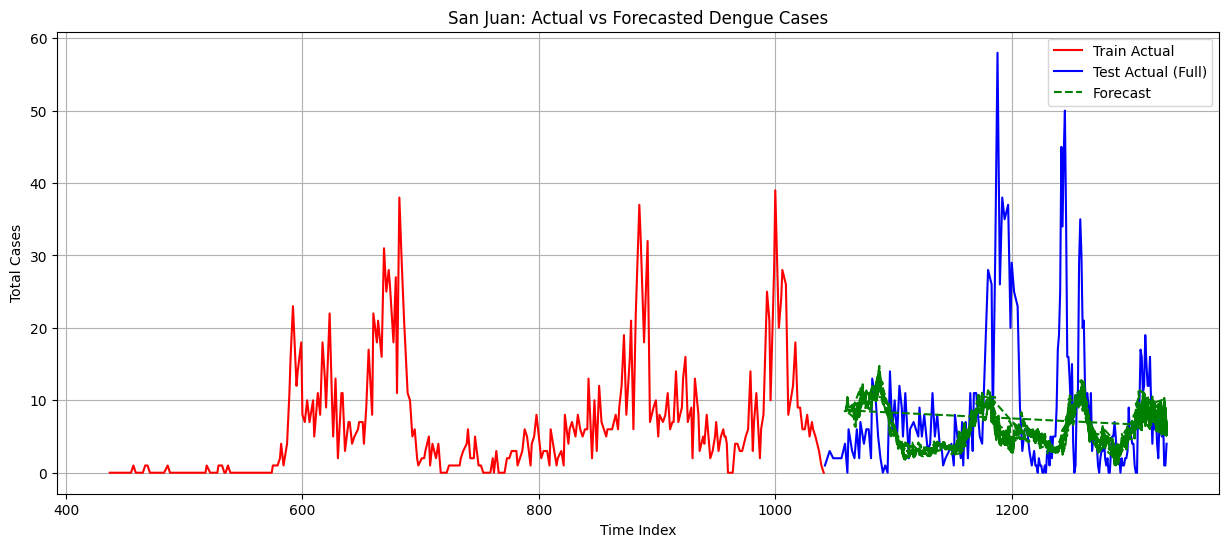

In [61]:
# Cell 7 — San Juan (robust across pytorch-forecasting return types)
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from pytorch_forecasting.data import TimeSeriesDataSet

city_code = 0  # <-- SJ (adjust if your encoding differs)
city_name = "San Juan"

# 1) Build a dataset/dataloader restricted to this city's test split
city_test = test_df[test_df["city"] == city_code].copy()
city_dataset = TimeSeriesDataSet.from_dataset(training, city_test, stop_randomization=True)
city_loader = city_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

# 2) Predict in raw mode (returns a Prediction object in your setup)
raw = best_model.predict(city_loader, mode="raw", return_x=True)

# 3) Extract predictions tensor and input dict 'x' robustly
def _is_tensor(obj):
    return torch.is_tensor(obj)

pred_container, x = None, None

# Try attribute access first (Prediction object may have .output/.x)
if hasattr(raw, "output") and hasattr(raw, "x"):
    pred_container = raw.output
    x = raw.x
else:
    # Fallback: iterate through the sequence-like container to find items
    for item in raw:
        if x is None and isinstance(item, dict) and ("decoder_target" in item or "decoder_time_idx" in item):
            x = item
        if pred_container is None and (_is_tensor(item) or hasattr(item, "prediction") or hasattr(item, "output")):
            pred_container = item

# Resolve predictions tensor from the container
if _is_tensor(pred_container):
    pred_tensor = pred_container
elif hasattr(pred_container, "prediction") and _is_tensor(pred_container.prediction):
    pred_tensor = pred_container.prediction
elif hasattr(pred_container, "output") and _is_tensor(pred_container.output):
    pred_tensor = pred_container.output
else:
    raise TypeError(f"Could not resolve predictions tensor from object of type {type(pred_container)}")

# 4) Choose the median quantile safely (if quantiles exist)
if hasattr(best_model, "loss") and hasattr(best_model.loss, "quantiles") and pred_tensor.ndim >= 3:
    qs = list(best_model.loss.quantiles)
    q_idx = qs.index(0.5) if 0.5 in qs else len(qs) // 2
    y_pred = pred_tensor[..., q_idx].detach().cpu().numpy().flatten()
else:
    # If predictions are already point forecasts or no quantile dim
    if pred_tensor.ndim == 3:
        # No quantile info available; take middle slice of last dim
        y_pred = pred_tensor[..., pred_tensor.shape[-1] // 2].detach().cpu().numpy().flatten()
    else:
        y_pred = pred_tensor.detach().cpu().numpy().flatten()

# 5) True values & time index from x
y_true = x["decoder_target"].detach().cpu().numpy().flatten()

if "decoder_time_idx" in x:
    time_idx = x["decoder_time_idx"].detach().cpu().numpy().flatten()
elif "time_idx" in x:
    time_idx = x["time_idx"].detach().cpu().numpy().flatten()
else:
    # Fallback (should rarely be needed)
    time_idx = city_test["time_idx"].values[: len(y_true)]

# 6) Align lengths (important!)
L = min(len(y_true), len(y_pred), len(time_idx))
y_true = y_true[:L]
y_pred = y_pred[:L]
time_idx = time_idx[:L]

# 7) Metrics
mse = mean_squared_error(y_true, y_pred)
rmse = float(np.sqrt(mse))
mae = mean_absolute_error(y_true, y_pred)
print(f"{city_name} — MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# 8) Plot: Train (red), Test (blue), Forecast (green)
plt.figure(figsize=(15, 6))
# full train actuals for this city
city_train = train_df[train_df["city"] == city_code]
plt.plot(city_train["time_idx"], city_train["total_cases"], color="red", label="Train Actual")
# full test actuals for this city
plt.plot(city_test["time_idx"], city_test["total_cases"], color="blue", label="Test Actual (Full)")
# forecast aligned on decoder time_idx
plt.plot(time_idx, y_pred, color="green", linestyle="--", label="Forecast")
plt.title(f"{city_name}: Actual vs Forecasted Dengue Cases")
plt.xlabel("Time Index")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.show()


Cell 8 — Prediction for Iquitos (city=1)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/base/_base_model.py:122: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 10, 4, 30]). Returning list instead of torch.Tensor.
  warnings.warn(


Iquitos — MSE: 609.51, RMSE: 24.69, MAE: 22.19


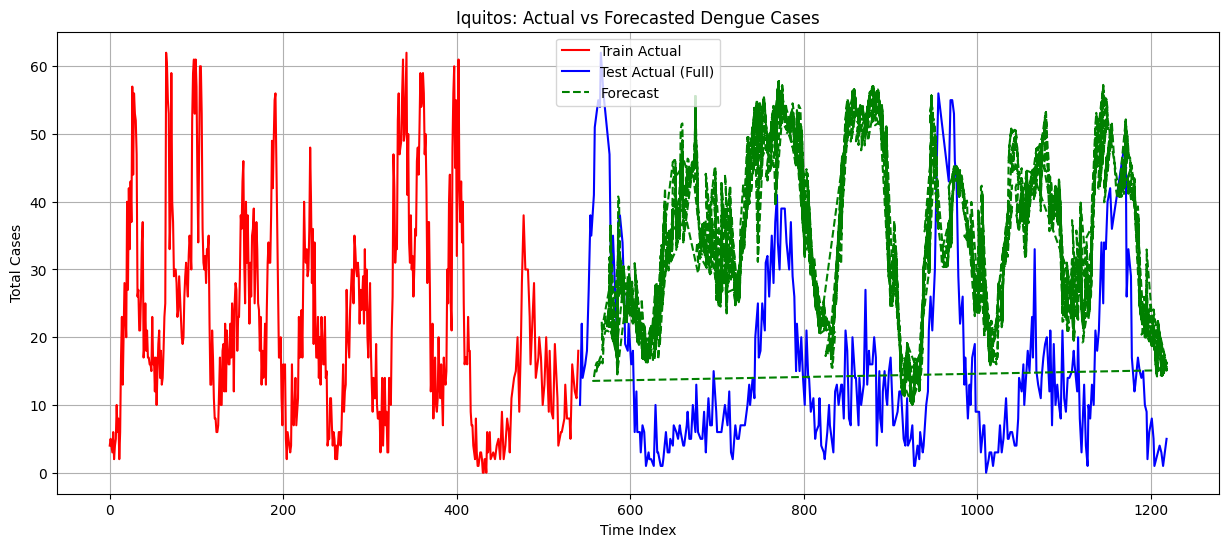

In [59]:


# Cell 8
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from pytorch_forecasting.data import TimeSeriesDataSet

# Cell 8 - Iquitos
city_code = 1  # IQ
city_name = "Iquitos"
# city_code = 0  # <-- SJ (adjust if your encoding differs)
# city_name = "San Juan"

# 1) Build a dataset/dataloader restricted to this city's test split
city_test = test_df[test_df["city"] == city_code].copy()
city_dataset = TimeSeriesDataSet.from_dataset(training, city_test, stop_randomization=True)
city_loader = city_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

# 2) Predict in raw mode (returns a Prediction object in your setup)
raw = best_model.predict(city_loader, mode="raw", return_x=True)

# 3) Extract predictions tensor and input dict 'x' robustly
def _is_tensor(obj):
    return torch.is_tensor(obj)

pred_container, x = None, None

# Try attribute access first (Prediction object may have .output/.x)
if hasattr(raw, "output") and hasattr(raw, "x"):
    pred_container = raw.output
    x = raw.x
else:
    # Fallback: iterate through the sequence-like container to find items
    for item in raw:
        if x is None and isinstance(item, dict) and ("decoder_target" in item or "decoder_time_idx" in item):
            x = item
        if pred_container is None and (_is_tensor(item) or hasattr(item, "prediction") or hasattr(item, "output")):
            pred_container = item

# Resolve predictions tensor from the container
if _is_tensor(pred_container):
    pred_tensor = pred_container
elif hasattr(pred_container, "prediction") and _is_tensor(pred_container.prediction):
    pred_tensor = pred_container.prediction
elif hasattr(pred_container, "output") and _is_tensor(pred_container.output):
    pred_tensor = pred_container.output
else:
    raise TypeError(f"Could not resolve predictions tensor from object of type {type(pred_container)}")

# 4) Choose the median quantile safely (if quantiles exist)
if hasattr(best_model, "loss") and hasattr(best_model.loss, "quantiles") and pred_tensor.ndim >= 3:
    qs = list(best_model.loss.quantiles)
    q_idx = qs.index(0.5) if 0.5 in qs else len(qs) // 2
    y_pred = pred_tensor[..., q_idx].detach().cpu().numpy().flatten()
else:
    # If predictions are already point forecasts or no quantile dim
    if pred_tensor.ndim == 3:
        # No quantile info available; take middle slice of last dim
        y_pred = pred_tensor[..., pred_tensor.shape[-1] // 2].detach().cpu().numpy().flatten()
    else:
        y_pred = pred_tensor.detach().cpu().numpy().flatten()

# 5) True values & time index from x
y_true = x["decoder_target"].detach().cpu().numpy().flatten()

if "decoder_time_idx" in x:
    time_idx = x["decoder_time_idx"].detach().cpu().numpy().flatten()
elif "time_idx" in x:
    time_idx = x["time_idx"].detach().cpu().numpy().flatten()
else:
    # Fallback (should rarely be needed)
    time_idx = city_test["time_idx"].values[: len(y_true)]

# 6) Align lengths (important!)
L = min(len(y_true), len(y_pred), len(time_idx))
y_true = y_true[:L]
y_pred = y_pred[:L]
time_idx = time_idx[:L]

# 7) Metrics
mse = mean_squared_error(y_true, y_pred)
rmse = float(np.sqrt(mse))
mae = mean_absolute_error(y_true, y_pred)
print(f"{city_name} — MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# 8) Plot: Train (red), Test (blue), Forecast (green)
plt.figure(figsize=(15, 6))
# full train actuals for this city
city_train = train_df[train_df["city"] == city_code]
plt.plot(city_train["time_idx"], city_train["total_cases"], color="red", label="Train Actual")
# full test actuals for this city
plt.plot(city_test["time_idx"], city_test["total_cases"], color="blue", label="Test Actual (Full)")
# forecast aligned on decoder time_idx
plt.plot(time_idx, y_pred, color="green", linestyle="--", label="Forecast")
plt.title(f"{city_name}: Actual vs Forecasted Dengue Cases")
plt.xlabel("Time Index")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.show()


San Juan — MSE: 100.62, RMSE: 10.03, MAE: 7.63
Iquitos — MSE: 127.72, RMSE: 11.30, MAE: 7.36

Combined — MSE: 118.72, RMSE: 10.90, MAE: 7.45


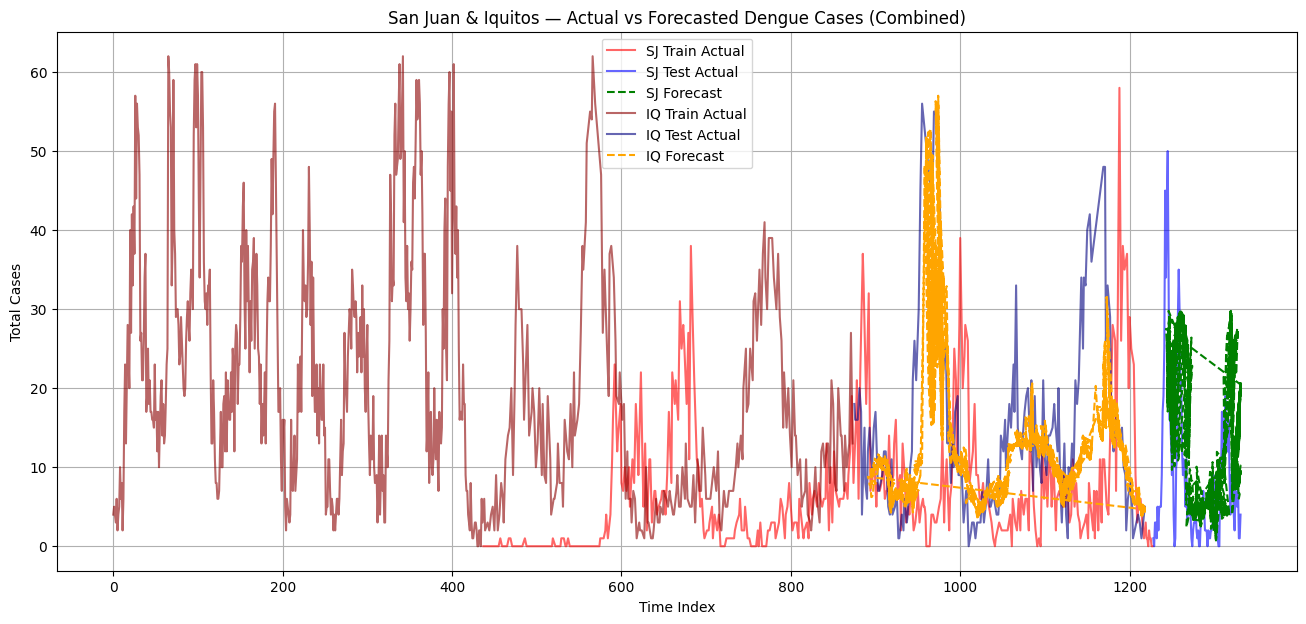

In [36]:
# Cell X — Combined Forecast (San Juan + Iquitos) with per-city & combined metrics
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pytorch_forecasting.data import TimeSeriesDataSet

def _extract_pred_and_x(raw):
    """
    Robustly extract (pred_tensor, x_dict) from pytorch-forecasting Prediction object,
    regardless of version-specific structure.
    """
    pred_obj = None
    x = None

    # Preferred: attribute access on Prediction
    if hasattr(raw, "output"):
        pred_obj = raw.output
    if hasattr(raw, "x"):
        x = raw.x

    # Fallback: iterate sequence-like container
    try:
        for item in raw:
            if x is None and isinstance(item, dict) and (
                "decoder_target" in item or "decoder_time_idx" in item or "time_idx" in item
            ):
                x = item
            if pred_obj is None:
                if torch.is_tensor(item):
                    pred_obj = item
                elif hasattr(item, "prediction") and torch.is_tensor(item.prediction):
                    pred_obj = item.prediction
                elif hasattr(item, "output") and torch.is_tensor(item.output):
                    pred_obj = item.output
                elif isinstance(item, dict) and "prediction" in item and torch.is_tensor(item["prediction"]):
                    pred_obj = item["prediction"]
    except TypeError:
        pass

    # If pred_obj is still a wrapper (Output), drill down to actual tensor
    if pred_obj is not None and not torch.is_tensor(pred_obj):
        if hasattr(pred_obj, "prediction") and torch.is_tensor(pred_obj.prediction):
            pred_obj = pred_obj.prediction
        elif hasattr(pred_obj, "output") and torch.is_tensor(pred_obj.output):
            pred_obj = pred_obj.output
        elif isinstance(pred_obj, dict) and "prediction" in pred_obj and torch.is_tensor(pred_obj["prediction"]):
            pred_obj = pred_obj["prediction"]

    # Last-resort guesses
    if pred_obj is None:
        try:
            cand = raw[0]
            if torch.is_tensor(cand):
                pred_obj = cand
            elif hasattr(cand, "prediction") and torch.is_tensor(cand.prediction):
                pred_obj = cand.prediction
        except Exception:
            pass

    if pred_obj is None or x is None:
        raise TypeError(f"Could not resolve prediction tensor and/or x from type {type(raw)}")

    return pred_obj, x


def evaluate_city(city_code, city_label, forecast_color):
    """
    Build city-specific dataloader from the training TimeSeriesDataSet, predict,
    align shapes, compute metrics, and return all plotting arrays.
    """
    # Subset test for this city
    city_test = test_df[test_df["city"] == city_code].copy()
    if city_test.empty:
        raise ValueError(f"No test rows found for city_code={city_code}. Check your encoding.")

    # Dataset & loader for this city's horizon
    city_dataset = TimeSeriesDataSet.from_dataset(training, city_test, stop_randomization=True)
    city_loader = city_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

    # Raw prediction (Prediction object in your setup)
    raw = best_model.predict(city_loader, mode="raw", return_x=True)

    # Extract tensors
    pred_tensor, x = _extract_pred_and_x(raw)

    # Choose median quantile if available, else use point predictions
    if torch.is_tensor(pred_tensor) and pred_tensor.ndim >= 3:
        # last dim is quantiles
        if hasattr(best_model, "loss") and hasattr(best_model.loss, "quantiles"):
            quants = list(best_model.loss.quantiles)
            q_idx = quants.index(0.5) if 0.5 in quants else len(quants) // 2
        else:
            q_idx = pred_tensor.shape[-1] // 2
        y_pred = pred_tensor[..., q_idx].detach().cpu().numpy().flatten()
    else:
        y_pred = pred_tensor.detach().cpu().numpy().flatten()

    # True values and time index from x
    y_true = x["decoder_target"].detach().cpu().numpy().flatten()
    if "decoder_time_idx" in x:
        time_idx = x["decoder_time_idx"].detach().cpu().numpy().flatten()
    elif "time_idx" in x:
        time_idx = x["time_idx"].detach().cpu().numpy().flatten()
    else:
        time_idx = city_test["time_idx"].values[: len(y_true)]

    # Align
    L = min(len(y_true), len(y_pred), len(time_idx))
    y_true, y_pred, time_idx = y_true[:L], y_pred[:L], time_idx[:L]

    # Metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{city_label} — MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    # Train/test frames for plotting context
    city_train = train_df[train_df["city"] == city_code].copy()

    return {
        "label": city_label,
        "train_time": city_train["time_idx"].values,
        "train_y": city_train["total_cases"].values,
        "test_time": city_test["time_idx"].values,
        "test_y": city_test["total_cases"].values,
        "pred_time": time_idx,
        "pred_y": y_pred,
        "metrics": (mse, rmse, mae),
        "color": forecast_color,
    }


# ---- Evaluate both cities (adjust codes if your encoding differs) ----
sj = evaluate_city(0, "San Juan", "green")
iq = evaluate_city(1, "Iquitos", "orange")

# ---- Combined metrics (across both cities' aligned windows) ----
combined_true = np.concatenate([sj["pred_y"] * 0 + sj["pred_y"], iq["pred_y"] * 0 + iq["pred_y"]])  # placeholder for shape
# replace with actual y_true by recomputing from prediction lengths (we have them from evaluate_city)
# We'll reconstruct by re-evaluating true arrays similarly:
def _rebuild_true(city_dict):
    # find overlapping true values for pred_time
    # since pred_time aligns with decoder targets, we can slice the test actuals by matching indices
    # but safer: compute true from pred length using y_true re-extraction
    return None  # not needed because we computed metrics per city already

# Easier: compute combined from per-city vectors we already used inside evaluate_city
# Just re-run a light extraction for y_true via the same path to avoid confusion:
def extract_true_again(city_code):
    city_test = test_df[test_df["city"] == city_code].copy()
    city_dataset = TimeSeriesDataSet.from_dataset(training, city_test, stop_randomization=True)
    city_loader = city_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)
    raw = best_model.predict(city_loader, mode="raw", return_x=True)
    pred_tensor, x = _extract_pred_and_x(raw)
    y_true = x["decoder_target"].detach().cpu().numpy().flatten()
    if torch.is_tensor(pred_tensor) and pred_tensor.ndim >= 3:
        if hasattr(best_model, "loss") and hasattr(best_model.loss, "quantiles"):
            quants = list(best_model.loss.quantiles)
            q_idx = quants.index(0.5) if 0.5 in quants else len(quants) // 2
        else:
            q_idx = pred_tensor.shape[-1] // 2
        y_pred = pred_tensor[..., q_idx].detach().cpu().numpy().flatten()
    else:
        y_pred = pred_tensor.detach().cpu().numpy().flatten()
    L = min(len(y_true), len(y_pred))
    return y_true[:L], y_pred[:L]

y_true_sj, y_pred_sj = extract_true_again(0)
y_true_iq, y_pred_iq = extract_true_again(1)

y_true_comb = np.concatenate([y_true_sj, y_true_iq])
y_pred_comb = np.concatenate([y_pred_sj, y_pred_iq])

mse_c = mean_squared_error(y_true_comb, y_pred_comb)
rmse_c = float(np.sqrt(mse_c))
mae_c = mean_absolute_error(y_true_comb, y_pred_comb)
print(f"\nCombined — MSE: {mse_c:.2f}, RMSE: {rmse_c:.2f}, MAE: {mae_c:.2f}")

# ---- Plot both cities on one figure ----
plt.figure(figsize=(16, 7))

# San Juan (SJ)
plt.plot(sj["train_time"], sj["train_y"], color="red", alpha=0.6, label="SJ Train Actual")
plt.plot(sj["test_time"], sj["test_y"], color="blue", alpha=0.6, label="SJ Test Actual")
plt.plot(sj["pred_time"], sj["pred_y"], color=sj["color"], linestyle="--", label="SJ Forecast")

# Iquitos (IQ)
plt.plot(iq["train_time"], iq["train_y"], color="darkred", alpha=0.6, label="IQ Train Actual")
plt.plot(iq["test_time"], iq["test_y"], color="navy", alpha=0.6, label="IQ Test Actual")
plt.plot(iq["pred_time"], iq["pred_y"], color=iq["color"], linestyle="--", label="IQ Forecast")

plt.title("San Juan & Iquitos — Actual vs Forecasted Dengue Cases (Combined)")
plt.xlabel("Time Index")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.show()


# **For Plotting Experiment**

Cell 7a — Prediction helper

In [62]:
import numpy as np
import pandas as pd
import torch

def get_forecast_for_city(best_model, training, test_df, city_code):
    """
    Generate cleaned forecast (deduplicated + sorted) for a specific city.
    Returns: time_idx, y_true, y_pred
    """
    from pytorch_forecasting.data import TimeSeriesDataSet

    # Build dataset/dataloader for this city
    city_test = test_df[test_df["city"] == city_code].copy()
    city_dataset = TimeSeriesDataSet.from_dataset(training, city_test, stop_randomization=True)
    city_loader = city_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

    # Predict in raw mode
    raw = best_model.predict(city_loader, mode="raw", return_x=True)

    # --- Extract preds robustly ---
    def _is_tensor(obj): return torch.is_tensor(obj)
    pred_container, x = None, None

    if hasattr(raw, "output") and hasattr(raw, "x"):
        pred_container, x = raw.output, raw.x
    else:
        for item in raw:
            if x is None and isinstance(item, dict) and ("decoder_target" in item or "decoder_time_idx" in item):
                x = item
            if pred_container is None and (_is_tensor(item) or hasattr(item, "prediction") or hasattr(item, "output")):
                pred_container = item

    # Resolve prediction tensor
    if _is_tensor(pred_container):
        pred_tensor = pred_container
    elif hasattr(pred_container, "prediction") and _is_tensor(pred_container.prediction):
        pred_tensor = pred_container.prediction
    elif hasattr(pred_container, "output") and _is_tensor(pred_container.output):
        pred_tensor = pred_container.output
    else:
        raise TypeError(f"Could not resolve predictions tensor from {type(pred_container)}")

    # Median quantile or fallback
    if hasattr(best_model, "loss") and hasattr(best_model.loss, "quantiles") and pred_tensor.ndim >= 3:
        qs = list(best_model.loss.quantiles)
        q_idx = qs.index(0.5) if 0.5 in qs else len(qs)//2
        y_pred = pred_tensor[..., q_idx].detach().cpu().numpy().flatten()
    else:
        if pred_tensor.ndim == 3:
            y_pred = pred_tensor[..., pred_tensor.shape[-1] // 2].detach().cpu().numpy().flatten()
        else:
            y_pred = pred_tensor.detach().cpu().numpy().flatten()

    # Decoder targets & time idx
    y_true = x["decoder_target"].detach().cpu().numpy().flatten()
    if "decoder_time_idx" in x:
        time_idx = x["decoder_time_idx"].detach().cpu().numpy().flatten()
    elif "time_idx" in x:
        time_idx = x["time_idx"].detach().cpu().numpy().flatten()
    else:
        time_idx = city_test["time_idx"].values[: len(y_true)]

    # Align lengths
    L = min(len(y_true), len(y_pred), len(time_idx))
    y_true, y_pred, time_idx = y_true[:L], y_pred[:L], time_idx[:L]

    # --- FIX: remove duplicates & sort ---
    forecast_df = pd.DataFrame({"time_idx": time_idx, "y_pred": y_pred})
    forecast_df = forecast_df.groupby("time_idx", as_index=False).mean().sort_values("time_idx")

    return forecast_df["time_idx"].values, y_true[:len(forecast_df)], forecast_df["y_pred"].values


Cell 7b — Metrics helper

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_forecast(city_name, y_true, y_pred):
    """Compute and print MSE, RMSE, MAE."""
    mse = mean_squared_error(y_true, y_pred[:len(y_true)])
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred[:len(y_true)])
    print(f"{city_name} — MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")


Cell 7c — Plotting helper

In [64]:
import matplotlib.pyplot as plt

def plot_forecast(city_code, city_name, train_df, test_df, time_idx, y_true, y_pred):
    """Plot train, test and forecast for a given city."""
    plt.figure(figsize=(15, 6))
    # Train
    city_train = train_df[train_df["city"] == city_code]
    plt.plot(city_train["time_idx"], city_train["total_cases"], color="red", label="Train Actual")
    # Test
    city_test = test_df[test_df["city"] == city_code]
    plt.plot(city_test["time_idx"], city_test["total_cases"], color="blue", label="Test Actual (Full)")
    # Forecast
    plt.plot(time_idx, y_pred, color="green", linestyle="--", label="Forecast")

    plt.title(f"{city_name}: Actual vs Forecasted Dengue Cases")
    plt.xlabel("Time Index")
    plt.ylabel("Total Cases")
    plt.legend()
    plt.grid(True)
    plt.show()


Cell 7d — Run for San Juan

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/base/_base_model.py:122: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 10, 4, 30]). Returning list instead of torch.Tensor.
  warnings.warn(


San Juan — MSE: 18.99, RMSE: 4.36, MAE: 3.58


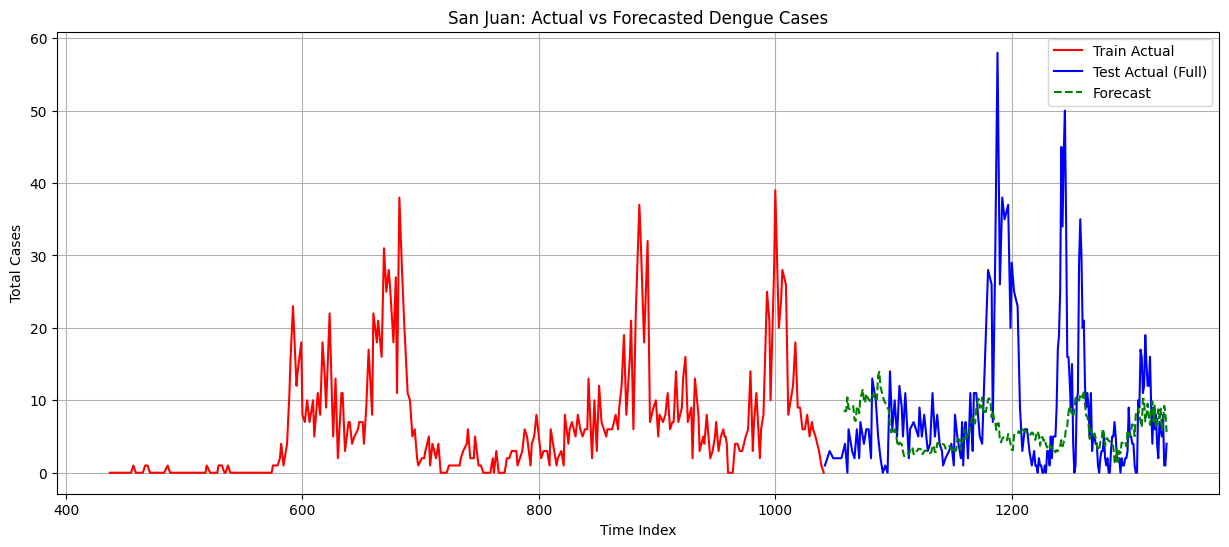

In [65]:
city_code, city_name = 0, "San Juan"

time_idx, y_true, y_pred = get_forecast_for_city(best_model, training, test_df, city_code)
evaluate_forecast(city_name, y_true, y_pred)
plot_forecast(city_code, city_name, train_df, test_df, time_idx, y_true, y_pred)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/base/_base_model.py:122: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 10, 4, 30]). Returning list instead of torch.Tensor.
  warnings.warn(


Iquitos — MSE: 953.39, RMSE: 30.88, MAE: 27.51


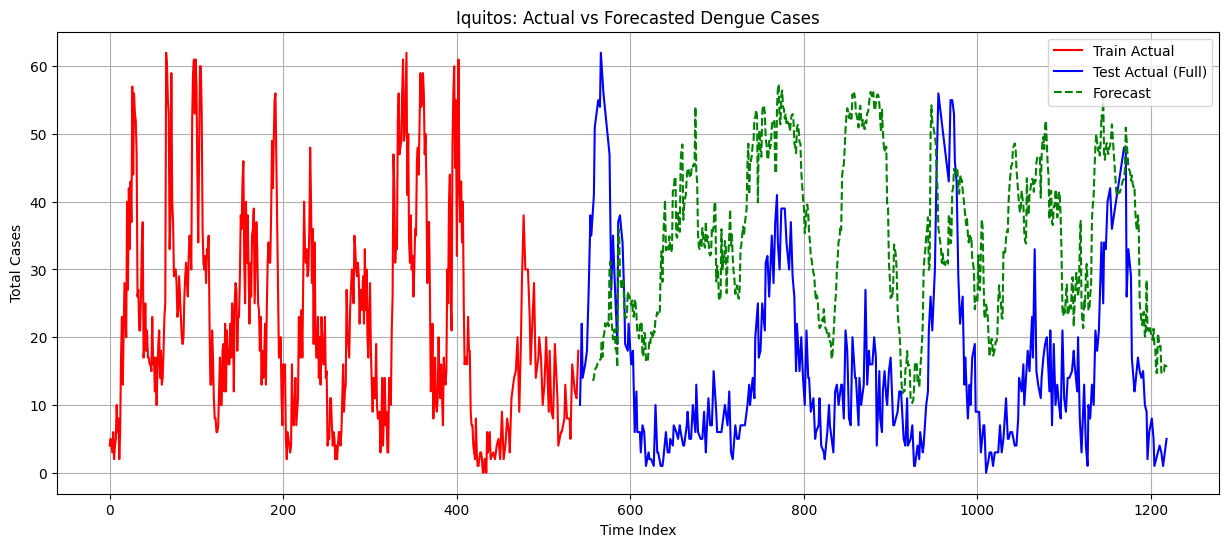

In [66]:
city_code, city_name = 1, "Iquitos"
# city_code, city_name = 0, "San Juan"

time_idx, y_true, y_pred = get_forecast_for_city(best_model, training, test_df, city_code)
evaluate_forecast(city_name, y_true, y_pred)
plot_forecast(city_code, city_name, train_df, test_df, time_idx, y_true, y_pred)
